# Covid data anlyses
For this project we used two types of covid data. In the following we are going to explain more where the data came from and how we processed it.

### 1. Covid lockdowns in France
We extracted covid lockdowns from this website: https://en.wikipedia.org/wiki/COVID-19_pandemic_in_France 
The created variable is a binary variable, stating 1 if for that day there was a lockdown in France. The data is added in the ML pipeline. For more details see `get_covid_data` in `problem.py`

### 2. Daily covid cases in France
We also added daily covid case data for France from the COVID-19 Data Repository by the Center for Systems Science and Engineering (CSSE) at Johns Hopkins University. The data was found here: https://github.com/CSSEGISandData/COVID-19. We give all credits to this reference: Dong E, Du H, Gardner L. An interactive web-based dashboard to track COVID-19 in real time. Lancet Inf Dis. 20(5):533-534. doi: 10.1016/S1473-3099(20)30120-1.

*Disclaimer: Both datasets are the work and property of the authors mentioned above, and we are not endorsed by none of these entities. We give all credits to the dataset creators, and we will use and modify the files in accordance with their license.*  

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

In the following we are going to load the covid cases data and process it to output one single external data file together with the weather data.

In [2]:
data_path = "../data"

In [3]:
covid_data = pd.read_csv(os.path.join(data_path, "time_series_covid19_confirmed_global.csv"))
covid_data.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,11/19/22,11/20/22,11/21/22,11/22/22,11/23/22,11/24/22,11/25/22,11/26/22,11/27/22,11/28/22
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,205039,205146,205229,205324,205391,205506,205541,205612,205612,205802
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,333246,333256,333257,333282,333293,333305,333316,333322,333330,333330
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,271011,271023,271028,271035,271041,271050,271057,271061,271061,271079
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,46824,46824,46824,46824,46824,46824,46824,46824,46824,46824
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,103131,103131,103131,103131,104491,104491,104491,104491,104491,104491


In [4]:
covid_france = covid_data.copy()
covid_france = covid_france.loc[(covid_france["Country/Region"]=="France") & (covid_france["Province/State"].isna()), :]
covid_france.drop(columns=["Province/State", "Country/Region", "Lat", "Long"], inplace=True)
covid_france

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,11/19/22,11/20/22,11/21/22,11/22/22,11/23/22,11/24/22,11/25/22,11/26/22,11/27/22,11/28/22
131,0,0,2,3,3,3,4,5,5,5,...,36297077,36297077,36365135,36429599,36478787,36529317,36577224,36577224,36577224,36671077


In [5]:
covid = covid_france.T

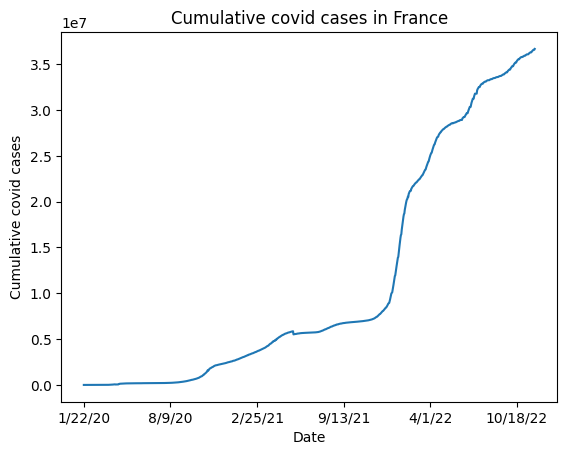

In [6]:
covid.plot(legend=None)
plt.xlabel("Date")
plt.ylabel("Cumulative covid cases")
plt.title("Cumulative covid cases in France");

We can see in the plot that around May 2021 there was some correction of the cumulative case number. We need to watch out for this in the following.

In [7]:
daily_covid = covid.diff()
daily_covid.reset_index(inplace=True)
daily_covid = daily_covid.rename(columns = {'index':'date', 131:'daily_covid_cases'})

In [8]:
daily_covid['date'] = pd.to_datetime(daily_covid['date'], format='%m/%d/%y')
daily_covid

,date,daily_covid_cases
0,2020-01-22,NaN
1,2020-01-23,0.0
2,2020-01-24,2.0
3,2020-01-25,1.0
4,2020-01-26,0.0
...,...,...
1037,2022-11-24,50530.0
1038,2022-11-25,47907.0
1039,2022-11-26,0.0
1040,2022-11-27,0.0


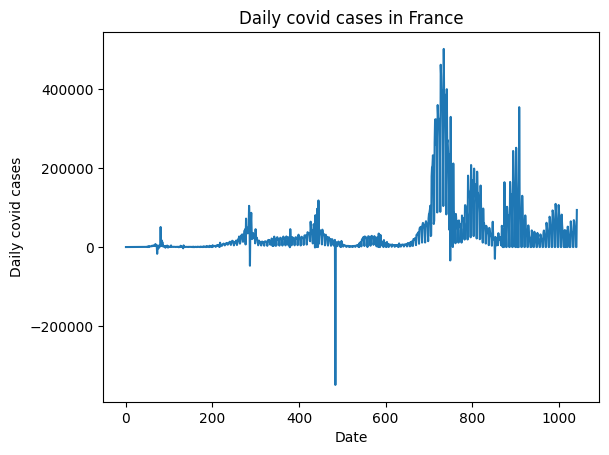

In [9]:
daily_covid.daily_covid_cases.plot(legend=None)
plt.xlabel("Date")
plt.ylabel("Daily covid cases")
plt.title("Daily covid cases in France");

As we can see, there are negative values that result from corrections. Those values are limited though and we are just going to set them to zero.

In [10]:
daily_covid.loc[daily_covid.daily_covid_cases.lt(0), "daily_covid_cases"] = 0

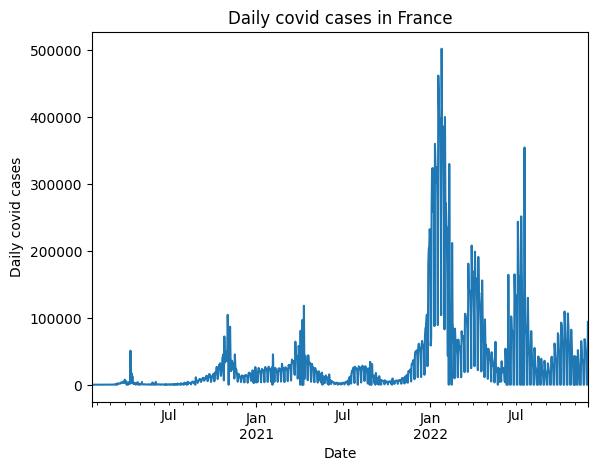

In [11]:
daily_covid.plot(x="date", legend=None)
plt.xlabel("Date")
plt.ylabel("Daily covid cases")
plt.title("Daily covid cases in France");

In [12]:
weather_data = pd.read_csv(
    "../data/weather_data_imp.csv",
    parse_dates=["date"],
    dtype={"wdir": "category", "rhum": "int"},
)
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11604 entries, 0 to 11603
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    11604 non-null  datetime64[ns]
 1   temp    11604 non-null  float64       
 2   dwpt    11604 non-null  float64       
 3   rhum    11604 non-null  int64         
 4   prcp    11604 non-null  float64       
 5   wdir    11604 non-null  category      
 6   wspd    11604 non-null  float64       
 7   pres    11604 non-null  float64       
dtypes: category(1), datetime64[ns](1), float64(5), int64(1)
memory usage: 646.7 KB


In [13]:
# merge all data sources
df_final = pd.merge_asof(weather_data.sort_values("date"), daily_covid.sort_values("date"), on="date")

In [14]:
df_final.head()

,date,temp,dwpt,rhum,prcp,wdir,wspd,pres,daily_covid_cases
0,2020-09-01 00:00:00,13.9,9.7,76,0.0,N,7.6,1020.4,4898.0
1,2020-09-01 01:00:00,13.6,9.6,77,0.0,NNW,3.6,1020.1,4898.0
2,2020-09-01 02:00:00,13.0,9.4,79,0.0,WNW,3.6,1019.9,4898.0
3,2020-09-01 03:00:00,12.9,9.7,81,0.0,NW,5.4,1019.8,4898.0
4,2020-09-01 04:00:00,12.4,9.6,83,0.0,WNW,5.4,1019.5,4898.0


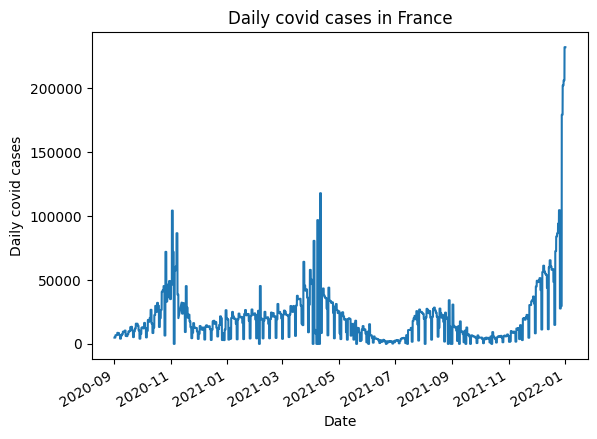

In [15]:
df_final.plot(x="date", y="daily_covid_cases", legend=None)
plt.xlabel("Date")
plt.ylabel("Daily covid cases")
plt.title("Daily covid cases in France");

In [16]:
df_final.to_csv(os.path.join(data_path, "external_data.csv"), index=False)